In [1]:
from IPython.display import clear_output

import os
import torch, torchvision
from torchvision import models
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

import utils
import competitors
import geex

random_seed = 1
torch.manual_seed(random_seed)

/srv/public/.local/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Preparation
- Loading pre-trained Inception-V3 and instances from IMAGENET 
- Initializing a GEEX instance
- Initializing an IG instance as a reference

In [2]:
# Loading images from IMAGENET/val for testing the explanation method
IMG_SIZE = (3, 299, 299) 
PIX_MEAN, PIX_STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
testset = torchvision.datasets.ImageFolder('files/IMAGENET/val', utils.preprocessing)
range_ptr = 85
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, sampler=utils.RangeSampler(range(range_ptr, range_ptr+5)))
test_iter = enumerate(test_loader)

m_core = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
m_core.cuda(), m_core.eval()
m = utils.SoftmaxWrapping(m_core)

In [3]:
# Initializing GEEX
num_masks, sigma = 5000, 0.3
smoothing_w, smoothing_sigma = 5, 0.7
baseline = 'blur'
expl_ge = geex.GEEX(num_masks, sigma, IMG_SIZE, baseline=baseline)
expl_ge.mask_smoothing(smoothing_w, smoothing_sigma)

# Initializing IG
expl_ig = competitors.IntegratedGrad(50, IMG_SIZE, baseline)

Smoothing masks: 100%|██████████| 79/79 [00:04<00:00, 18.35it/s]


### Visualization of the explanation results via saliency maps

100%|██████████| 79/79 [00:08<00:00,  9.37it/s]


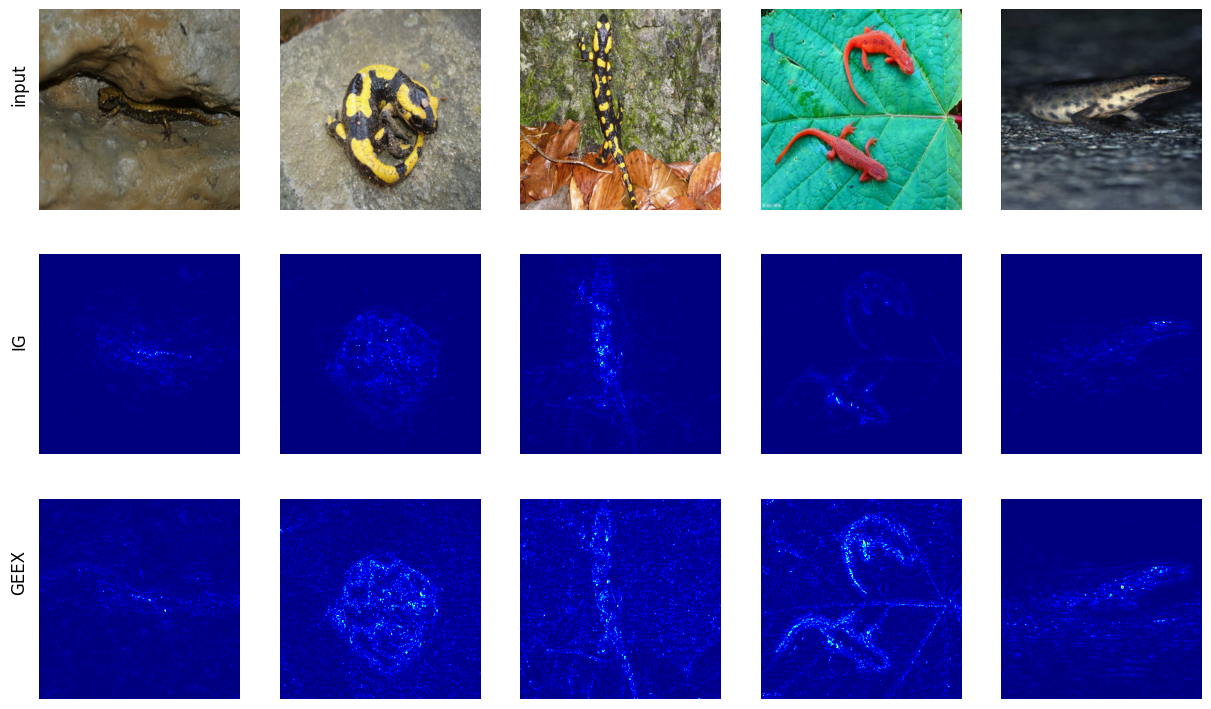

In [4]:
cmap = 'jet'
expls = [expl_ig, expl_ge]

examples2show = 5
rels2show = len(expls)+1
fig, axs = plt.subplots(rels2show, examples2show, figsize=(3*examples2show, 3*rels2show))
for row in axs: 
    for ax in row: ax.axis('off')

for i, title in enumerate(['input', 'IG', 'GEEX']):
    axs[i][0].set_title(title, rotation='vertical', x=-0.1, y=0.5)

for col_id, (batch_imgs, batch_labels) in test_iter:
    if col_id >= examples2show: break
    img = batch_imgs[0].unsqueeze(dim=0)
    img2show = utils.denormalize_imagenet(img[0].permute(1,2,0))
    axs[0][col_id].imshow(img2show)

    for row_id, expl in enumerate(expls):
        rel = expl.explain(m, img, verbose=True)[0] if isinstance(expl, geex.GEEX) else expl.explain(m, img)[0]
        rel = torch.abs(rel)
        axs[row_id+1][col_id].imshow(rel, cmap=cmap)

### Evaluate explainers with normalized AOPCs

In [5]:
import evaluation

In [6]:
for expl in expls:
    records = evaluation.evaluate_via_deletion(
        expl, m, test_loader, IMG_SIZE, v_default='blur', 
        num_instances=5, stride=100
        )
    aopc = evaluation.compute_aopc(torch.tensor(records).mean(dim=0))
    print(f'AOPC of [{expl.__class__}]: {aopc}')

Num of instances for evaluation: 5


#Instances: 100%|██████████| 5/5 [00:34<00:00,  6.89s/it, Current edition: [89500/89401]]


AOPC of [<class 'competitors.IntegratedGrad'>]: 0.9083372354507446
Num of instances for evaluation: 5


#Instances: 100%|██████████| 5/5 [01:09<00:00, 13.81s/it, Current edition: [89500/89401]]

AOPC of [<class 'geex.GEEX'>]: 0.8290084600448608
